In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
import dask.distributed as dsk

# Start Client/ dask runs together with xarray to improve performance. Only need to initialize once here.
clnt = dsk.Client()

In [2]:
# path to directory of AWRA model data
awra_dir = '/g/data/fj8/BoM/AWRA/DATA/'


# selecting a time slice and specific latitude and longitude to work on a single grid cell
time_slice = slice('1980-01-01', '2022-12-31')
lat_sel = -37
lon_sel = 148

In [3]:
fd = xr.open_dataset('/g/data/w97/aj8747/fd_summer_project/fd_sm_start.nc')
fd['sm_pct'].dropna(dim = 'time')

<xarray.DataArray 'sm_pct' (time: 151)>
array([0.442254, 0.430588, 0.437388, 0.430019, 0.422903, 0.414275, 0.447263,
       0.440526, 0.866418, 0.852368, 0.838957, 0.694434, 0.685912, 0.677313,
       0.694393, 0.703106, 0.703042, 0.705589, 0.773731, 0.49892 , 0.487598,
       0.476865, 0.465914, 0.456605, 0.447173, 0.761945, 0.797246, 0.786884,
       0.774444, 0.771539, 0.768736, 0.757441, 0.746563, 0.447737, 0.439907,
       0.794647, 0.782575, 0.770801, 0.76494 , 0.622896, 0.832396, 0.818147,
       0.805317, 0.804382, 0.791185, 0.777686, 0.764103, 0.750332, 0.736929,
       0.722805, 0.711222, 0.697555, 0.453799, 0.444104, 0.436767, 0.444863,
       0.438863, 0.69726 , 0.790419, 0.798684, 0.791818, 0.75021 , 0.453509,
       0.445574, 0.439151, 0.742262, 0.735761, 0.727865, 0.718583, 0.709044,
       0.716273, 0.703962, 0.636984, 0.411953, 0.414448, 0.41423 , 0.405358,
       0.757959, 0.74685 , 0.756818, 0.755451, 0.698313, 0.42569 , 0.4171  ,
       0.409157, 0.401737, 0.499922, 0.491523, 0.483101, 0.47526 , 0.466997,
       0.795096, 0.783971, 0.773054, 0.779781, 0.75792 , 0.745792, 0.732432,
       0.753963, 0.74118 , 0.727909, 0.767075, 0.75272 , 0.73856 , 0.724963,
       0.711828, 0.747821, 0.742647, 0.75344 , 0.755938, 0.742326, 0.728272,
       0.715965, 0.702373, 0.688701, 0.485645, 0.486888, 0.485915, 0.479473,
       0.711646, 0.704781, 0.844177, 0.820843, 0.807455, 0.794851, 0.743259,
       0.730647, 0.542118, 0.458793, 0.445845, 0.492533, 0.796373, 0.789364,
       0.778287, 0.767366, 0.717183, 0.698467, 0.689417, 0.680444, 0.671727,
       0.754482, 0.755945, 0.744434, 0.78313 , 0.770033, 0.760005, 0.750204,
       0.810563, 0.799359, 0.786625, 0.761803], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-02-15 1980-02-16 ... 2020-09-03
    latitude   float64 ...
    longitude  float64 ...
Attributes:
    name:           sm_pct
    units:          Fraction of fullness
    long_name:      Total rootzone soil moisture (0-100 cm)
    standard_name:  sm_pct

In [4]:
# Convert to pandas dataframe 
df = fd.to_dataframe()
#df.drop(columns = ['latitude','longitude'], inplace=True)
df['num_index'] = range(0,len(df))

In [5]:
etot_dir = awra_dir + 'SCHEDULED-V6/etot_*.nc'
ds_et = xr.open_mfdataset(etot_dir, chunks = {'time':'200mb'}, parallel = True)

# data at a grid point and a specific time
da_et = ds_et.sel(latitude = lat_sel, longitude = lon_sel, time = time_slice)
da_et = da_et.load()

#array of ET
ET = da_et['etot']
ET

<xarray.DataArray 'etot' (time: 15706)>
array([2.30656389, 2.60561533, 3.51802028, ..., 2.68731477, 2.68991549,
       6.00248327])
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-12-31
    latitude   float64 -37.0
    longitude  float64 148.0
Attributes:
    long_name:      etot
    units:          mm
    name:           etot
    standard_name:  etot

In [6]:
# Find the mean ET values in the 20 days before each FD start (could also try min instead of mean)

df['ET'] = np.nan #adding new columns 
df['-20d_ET'] = np.nan
for row in df.index: #index is datetime
    df.loc[row, 'ET'] = ET.sel(time=row)
    if ~np.isnan(df.loc[row,'sm_pct']):
        # Provided we're more than 20 days from the start of the timeseries, find the mean ET from the 20 days before each FD
        if row -  pd.to_timedelta(20, unit='d') > df.index[0]: #if the row number and 20 days before is larger than the first date
            df.loc[row, '-20d_ET'] = np.nanmean(df.loc[row-pd.to_timedelta(20, unit='d'):row]['ET'])
df

,latitude,longitude,sm_pct,num_index,ET,-20d_ET
time,,,,,,
1980-01-01,-37.0,148.0,NaN,0,2.306564,NaN
1980-01-02,-37.0,148.0,NaN,1,2.605615,NaN
1980-01-03,-37.0,148.0,NaN,2,3.518020,NaN
1980-01-04,-37.0,148.0,NaN,3,5.368407,NaN
1980-01-05,-37.0,148.0,NaN,4,3.738397,NaN
...,...,...,...,...,...,...
2022-12-27,-37.0,148.0,NaN,15701,5.087646,NaN
2022-12-28,-37.0,148.0,NaN,15702,3.178666,NaN
2022-12-29,-37.0,148.0,NaN,15703,2.687315,NaN


In [7]:
# Find the dates that have a FD start, and where the mean ET in the 20 days before was >= 80% of the climatological ET

# First get climatology of ET - here I create a monthly climatology, but you can change it to be
# a day of year or seasonal climatology if you want. Alternatively, if you want to be really specific, you can create 
# a climatology of every 20-day period your checking.
clim_mon = df['ET'].groupby(df.index.month).mean()

# Create a binary column that tells us whether the ET of the prior 20 days was more than 80% of the climatological value
df['-20d_ET_above80pct'] = np.nan
df['-20d_ET_above80pct'] = np.nan
for row in df.index:
    clim_value = clim_mon[row.month]
    # Check if -20day mean is above monthly clim value
    if ~np.isnan(df.loc[row,'-20d_ET']):
        if df.loc[row,'-20d_ET'] >= clim_value*0.8:
            df.loc[row,'-20d_ET_above80pct'] = 1
            
df

,latitude,longitude,sm_pct,num_index,ET,-20d_ET,-20d_ET_above80pct
time,,,,,,,
1980-01-01,-37.0,148.0,NaN,0,2.306564,NaN,NaN
1980-01-02,-37.0,148.0,NaN,1,2.605615,NaN,NaN
1980-01-03,-37.0,148.0,NaN,2,3.518020,NaN,NaN
1980-01-04,-37.0,148.0,NaN,3,5.368407,NaN,NaN
1980-01-05,-37.0,148.0,NaN,4,3.738397,NaN,NaN
...,...,...,...,...,...,...,...
2022-12-27,-37.0,148.0,NaN,15701,5.087646,NaN,NaN
2022-12-28,-37.0,148.0,NaN,15702,3.178666,NaN,NaN
2022-12-29,-37.0,148.0,NaN,15703,2.687315,NaN,NaN


<AxesSubplot:xlabel='time'>

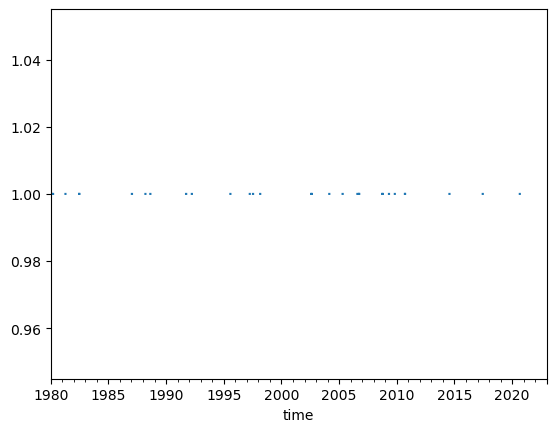

In [8]:
df['-20d_ET_above80pct'].plot()

In [9]:
# Koster defines FDs as those where SM falls from one percentile (e.g. 40th) to another within 20 days. Assuming the FD days in 
# '/g/data/w97/aj8747/fd_summer_project/fd_sm_start_dates.nc' have been identified in a similar way, I'm going to assume each FD
# identified in the FD_start column lasts for at least 20days. Then I will find the mean/min ET over the 20 days after those.
#this has to be done from end of flash drought. Ignore for now

fe = xr.open_dataset('/g/data/w97/aj8747/fd_summer_project/fd_sm_end.nc')


# Convert to pandas dataframe 
de = fe.to_dataframe()
#de.drop(columns = ['latitude','longitude'], inplace=True)
de['num_index'] = range(0,len(df))
# Create a binary column where flash droughts have been previously identified
de['timing'] = 0
for row in de.index:
    if ~np.isnan(df.loc[row, 'sm_pct']):
        de.loc[row,'timing']=1
de #given the flash drought timing the value 1, and the nan values 0

,latitude,longitude,sm_pct,num_index,timing
time,,,,,
1980-01-01,-37.0,148.0,NaN,0,0
1980-01-02,-37.0,148.0,NaN,1,0
1980-01-03,-37.0,148.0,NaN,2,0
1980-01-04,-37.0,148.0,NaN,3,0
1980-01-05,-37.0,148.0,NaN,4,0
...,...,...,...,...,...
2022-12-27,-37.0,148.0,NaN,15701,0
2022-12-28,-37.0,148.0,NaN,15702,0
2022-12-29,-37.0,148.0,NaN,15703,0


In [10]:
df['+20d_ET'] = np.nan
for row in df.index:
    if ~np.isnan(df.loc[row,'sm_pct']):
        # Provided we're more than 20 days from the end of the timeseries, find the mean ET from the 20 days before each FD
        if row + pd.to_timedelta(20, unit='d') < df.index[-1]: #if the end time stamp is bigger than the 20 days after
            df.loc[row, '+20d_ET'] = np.nanmean(df.loc[row+pd.to_timedelta(20, unit='d') : row+pd.to_timedelta(40, unit='d')]['ET'])
# the last line goes from day 20 to day 40?        
df

,latitude,longitude,sm_pct,num_index,ET,-20d_ET,-20d_ET_above80pct,+20d_ET
time,,,,,,,,
1980-01-01,-37.0,148.0,NaN,0,2.306564,NaN,NaN,NaN
1980-01-02,-37.0,148.0,NaN,1,2.605615,NaN,NaN,NaN
1980-01-03,-37.0,148.0,NaN,2,3.518020,NaN,NaN,NaN
1980-01-04,-37.0,148.0,NaN,3,5.368407,NaN,NaN,NaN
1980-01-05,-37.0,148.0,NaN,4,3.738397,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-12-27,-37.0,148.0,NaN,15701,5.087646,NaN,NaN,NaN
2022-12-28,-37.0,148.0,NaN,15702,3.178666,NaN,NaN,NaN
2022-12-29,-37.0,148.0,NaN,15703,2.687315,NaN,NaN,NaN


In [11]:
# Create a binary column that tells us whether the ET of the 20 days following the 20-day FD identificaiton period was less than 60% of the climatological value
df['+20d_ET_below60pct'] = np.nan
for row in df.index:
    clim_value = clim_mon[row.month]
    # Check if +20day mean is above monthly clim value
    if ~np.isnan(df.loc[row,'+20d_ET']):
        if df.loc[row,'+20d_ET'] <= clim_value*0.6:
            df.loc[row,'+20d_ET_below60pct'] = 1
            


In [12]:
# Now put it all together. We can identify "true" flash droughts as those where:
#   FD_start = a valid SM number
#   -20d_ET_above80pct = 1
#   +20d_ET_below60pct = 1
# Based on the output, we find 5 FD instances between 1980 and 2022.

df['True_FD'] = 0
for row in df.index:
    if ~np.isnan(df.loc[row, 'sm_pct']):
        if df.loc[row,'-20d_ET_above80pct'] == 1:
            if df.loc[row,'+20d_ET_below60pct'] == 1:
                df.loc[row, 'True_FD'] = 1
                
df.loc[df.True_FD==1]

,latitude,longitude,sm_pct,num_index,ET,-20d_ET,-20d_ET_above80pct,+20d_ET,+20d_ET_below60pct,True_FD
time,,,,,,,,,,
1980-03-14,-37.0,148.0,0.437388,73,1.840308,2.033535,1.0,1.180936,1.0,1
1980-03-15,-37.0,148.0,0.430019,74,1.606545,1.991496,1.0,1.172368,1.0,1
1980-03-16,-37.0,148.0,0.422903,75,1.535982,1.978030,1.0,1.167650,1.0,1
1980-03-17,-37.0,148.0,0.414275,76,2.261897,2.008936,1.0,1.136339,1.0,1
1981-04-11,-37.0,148.0,0.447263,466,1.546262,1.819800,1.0,0.906440,1.0,1
1981-04-12,-37.0,148.0,0.440526,467,1.982643,1.825312,1.0,0.901645,1.0,1
1992-03-25,-37.0,148.0,0.453799,4467,2.111876,2.343867,1.0,1.035979,1.0,1
1992-03-26,-37.0,148.0,0.444104,4468,2.462608,2.308694,1.0,1.011742,1.0,1
1992-03-27,-37.0,148.0,0.436767,4469,1.621372,2.254190,1.0,1.032711,1.0,1


In [13]:
# Filter out overlapping periods. Chosing the first one
TFD = df.True_FD.values #getting the values for the True_FD row in the above dataframe
no_overlap = [] #empty list for no overlap
end = 0 
for i in range(len(df)): #for index in length of dataframe
    start = next(x for x in np.arange(end,len(TFD)) if TFD[x]==1)
    #print(i,start)
    # If there's an instance at the end of the timeseries, still append it
    if len(TFD[start:]) - np.count_nonzero(TFD[start:]) == 0: # i.e. if there's an instance at the end or near
        # the end of the timeseries, and all subsequent timesteps are 0, you've accounted for all the starts. 
        pass
    else:
        end = next(x for x in np.arange(start,len(TFD)) if TFD[x]==0)
    #print(i,start,end)    
    no_overlap.append(start)  
    # If you've found the last instance, the loop can stop.
    if np.count_nonzero(TFD[end:]) == 0:
        break

no_overlap

[73, 466, 4467, 6631, 8819, 9242]

In [14]:
#beginnings of flash drought periods without overlap. 

# Mark the days that the flash droughts begin
df['FD_start'] = np.nan #create a new column in the dataframe
for row in df.index: #for row in the new index
    if df.loc[row,'num_index'] in no_overlap: #if the loc is row and num_index in instances found above
        df.loc[row, 'FD_start'] = df.loc[row,'sm_pct'] #then the row and FD_start is the row and soil moisture value in instances

In [15]:
filtered_df = df[df['FD_start'].notnull()]
filtered_df

,latitude,longitude,sm_pct,num_index,ET,-20d_ET,-20d_ET_above80pct,+20d_ET,+20d_ET_below60pct,True_FD,FD_start
time,,,,,,,,,,,
1980-03-14,-37.0,148.0,0.437388,73,1.840308,2.033535,1.0,1.180936,1.0,1,0.437388
1981-04-11,-37.0,148.0,0.447263,466,1.546262,1.819800,1.0,0.906440,1.0,1,0.447263
1992-03-25,-37.0,148.0,0.453799,4467,2.111876,2.343867,1.0,1.035979,1.0,1,0.453799
1998-02-26,-37.0,148.0,0.411953,6631,3.391842,2.538868,1.0,1.466008,1.0,1,0.411953
2004-02-23,-37.0,148.0,0.425690,8819,2.373741,3.235267,1.0,1.490988,1.0,1,0.425690
2005-04-21,-37.0,148.0,0.491523,9242,1.623016,1.806620,1.0,0.898456,1.0,1,0.491523


In [16]:
# Create a binary column where flash droughts have been previously identified
df['timing'] = 0
for row in df.index:
    if ~np.isnan(df.loc[row, 'FD_start']):
        df.loc[row,'timing']=1

df.loc[df.timing==1]

,latitude,longitude,sm_pct,num_index,ET,-20d_ET,-20d_ET_above80pct,+20d_ET,+20d_ET_below60pct,True_FD,FD_start,timing
time,,,,,,,,,,,,
1980-03-14,-37.0,148.0,0.437388,73,1.840308,2.033535,1.0,1.180936,1.0,1,0.437388,1
1981-04-11,-37.0,148.0,0.447263,466,1.546262,1.819800,1.0,0.906440,1.0,1,0.447263,1
1992-03-25,-37.0,148.0,0.453799,4467,2.111876,2.343867,1.0,1.035979,1.0,1,0.453799,1
1998-02-26,-37.0,148.0,0.411953,6631,3.391842,2.538868,1.0,1.466008,1.0,1,0.411953,1
2004-02-23,-37.0,148.0,0.425690,8819,2.373741,3.235267,1.0,1.490988,1.0,1,0.425690,1
2005-04-21,-37.0,148.0,0.491523,9242,1.623016,1.806620,1.0,0.898456,1.0,1,0.491523,1


<AxesSubplot:xlabel='time'>

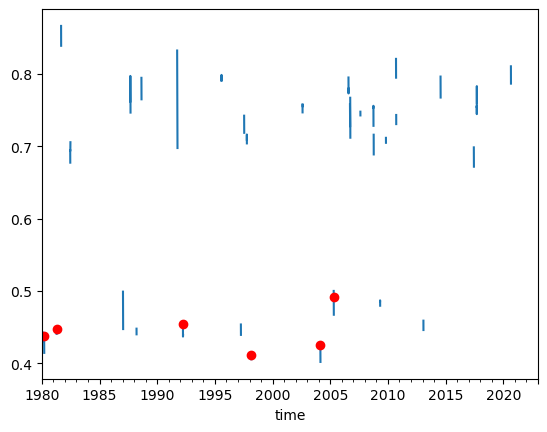

In [17]:
#Plot to visualise where we actually have flash droughts with no overlap compared to all possible dates
df.sm_pct.plot()
df.FD_start.plot(color='r',marker='o')